<a href="https://colab.research.google.com/github/Rad-Monk/TF-Notebooks/blob/main/Vision_TL_and_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.15.0


In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin= _URL, extract = True)
PATH = os.path.join(os.path.dirname(path_to_zip),'cats_and_dogs_filtered')

train_dir= os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)

68606236/68606236 [==============================] - 0s 0us/step


In [ ]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
class_names = raw_train_ds.class_names

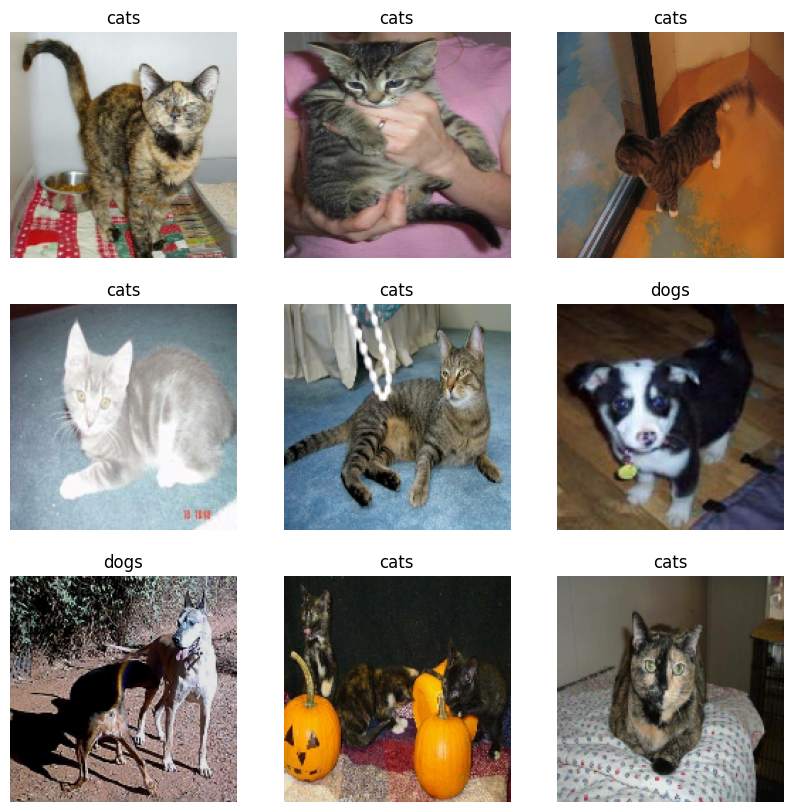

In [ ]:
plt.figure(figsize= (10,10))
for images, labels in raw_train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
val_batches = tf.data.experimental.cardinality(raw_val_ds)
print(val_batches)

tf.Tensor(32, shape=(), dtype=int64)


In [ ]:
raw_test_ds = raw_val_ds.take(val_batches // 5)
raw_val_ds = raw_val_ds.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

raw_train_ds = raw_train_ds.cache().prefetch(buffer_size = AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size = AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(.2)
])

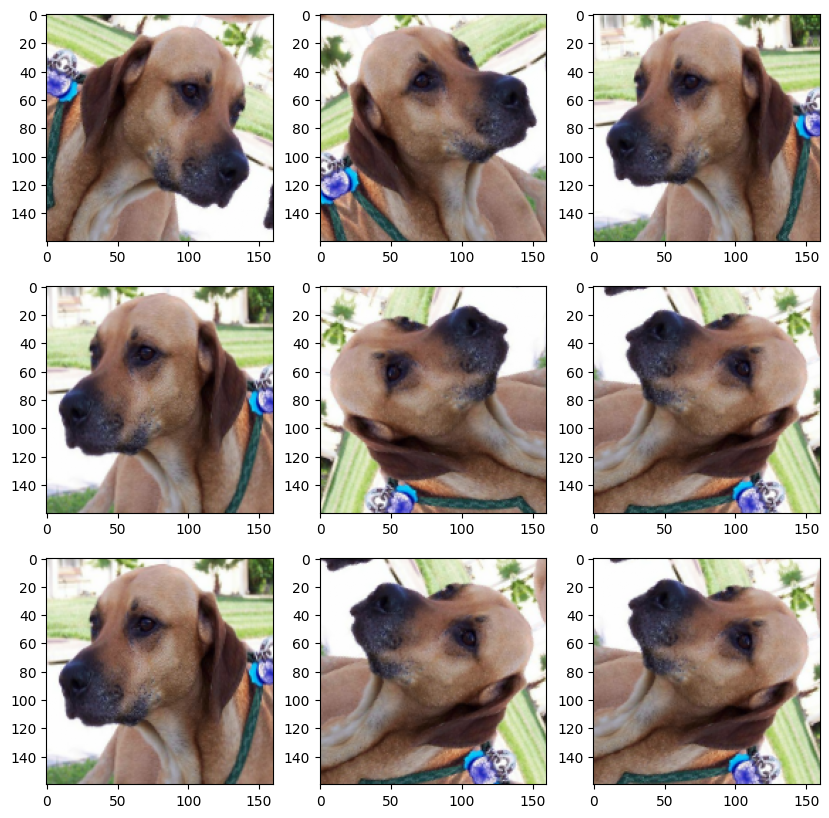

In [ ]:
for image, _ in raw_train_ds.take(1):
  plt.figure(figsize = (10,10))
  first_image = image[9]
  for i in range(9):
    plt.subplot(3,3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet'
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(raw_train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation= 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape = (160,160,3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0   

In [ ]:
(model.trainable_variables)

[<tf.Variable 'dense_2/kernel:0' shape=(1280, 1) dtype=float32, numpy=
 array([[ 0.05250701],
        [-0.00654377],
        [-0.04087005],
        ...,
        [-0.06471581],
        [ 0.05589019],
        [-0.06748135]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

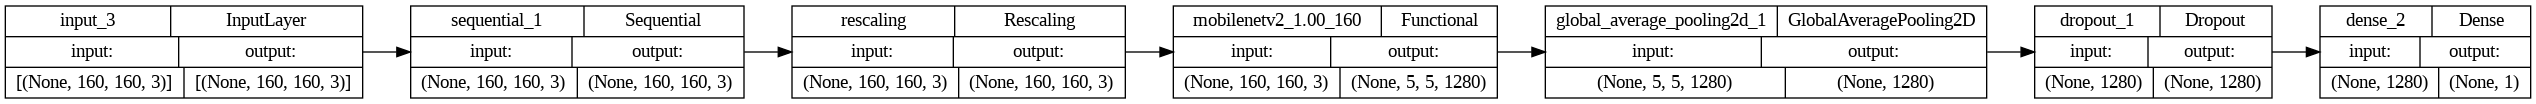

In [ ]:
tf.keras.utils.plot_model(model, rankdir = 'LR',show_shapes = True )

In [ ]:
base_learning_rate = .0001
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy(threshold = .5, name = 'accuracy')]
)

In [ ]:
initial_epoch = 10

loss0, accuracy0 = model.evaluate(raw_val_ds)

26/26 [==============================] - 16s 568ms/step - loss: 0.7452 - accuracy: 0.5235


In [ ]:
history = model.fit(
    raw_train_ds,
    epochs = initial_epoch,
    validation_data = raw_val_ds
)

Epoch 1/10
63/63 [==============================] - 60s 894ms/step - loss: 0.6830 - accuracy: 0.6080 - val_loss: 0.5111 - val_accuracy: 0.7562
Epoch 2/10
63/63 [==============================] - 66s 1s/step - loss: 0.5143 - accuracy: 0.7545 - val_loss: 0.3694 - val_accuracy: 0.8837
Epoch 3/10
63/63 [==============================] - 60s 954ms/step - loss: 0.4043 - accuracy: 0.8340 - val_loss: 0.2863 - val_accuracy: 0.9295
Epoch 4/10
63/63 [==============================] - 63s 1s/step - loss: 0.3589 - accuracy: 0.8560 - val_loss: 0.2360 - val_accuracy: 0.9480
Epoch 5/10
63/63 [==============================] - 66s 1s/step - loss: 0.2908 - accuracy: 0.8915 - val_loss: 0.2008 - val_accuracy: 0.9616
Epoch 6/10
63/63 [==============================] - 82s 1s/step - loss: 0.2882 - accuracy: 0.8925 - val_loss: 0.1765 - val_accuracy: 0.9641
Epoch 7/10
63/63 [==============================] - 76s 1s/step - loss: 0.2515 - accuracy: 0.9050 - val_loss: 0.1586 - val_accuracy: 0.9691
Epoch 8/10
63/

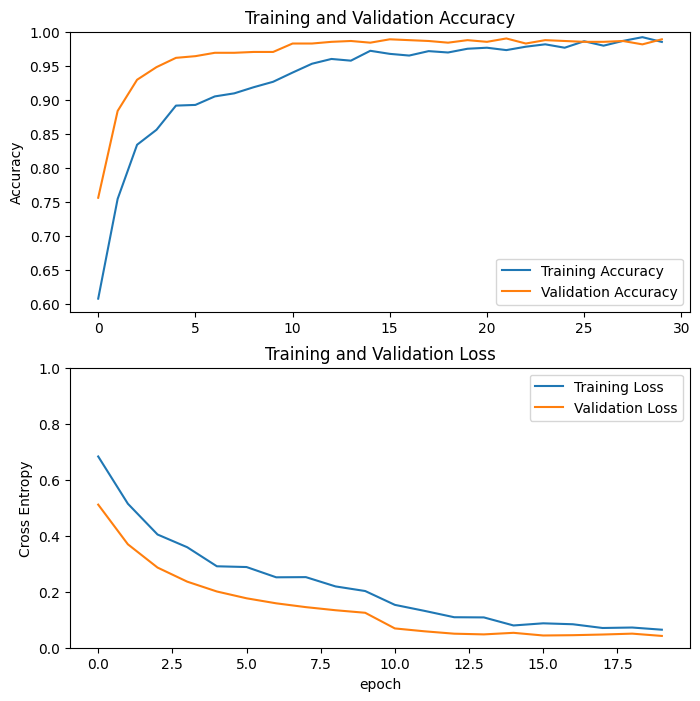

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
print(len(base_model.layers))
fine_tune_at = 100

154


In [ ]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0   

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs = fine_tune_epochs + initial_epoch

history_fine = model.fit(
    raw_train_ds,
    epochs = total_epochs,
    initial_epoch = len(history.epoch),
    validation_data = raw_val_ds
)

Epoch 11/20
63/63 [==============================] - 96s 1s/step - loss: 0.0545 - accuracy: 0.9765 - val_loss: 0.0488 - val_accuracy: 0.9851
Epoch 12/20
63/63 [==============================] - 82s 1s/step - loss: 0.0626 - accuracy: 0.9730 - val_loss: 0.0375 - val_accuracy: 0.9901
Epoch 13/20
63/63 [==============================] - 74s 1s/step - loss: 0.0532 - accuracy: 0.9780 - val_loss: 0.0442 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 76s 1s/step - loss: 0.0478 - accuracy: 0.9815 - val_loss: 0.0429 - val_accuracy: 0.9876
Epoch 15/20
63/63 [==============================] - 81s 1s/step - loss: 0.0538 - accuracy: 0.9765 - val_loss: 0.0386 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 74s 1s/step - loss: 0.0371 - accuracy: 0.9860 - val_loss: 0.0424 - val_accuracy: 0.9851
Epoch 17/20
63/63 [==============================] - 74s 1s/step - loss: 0.0500 - accuracy: 0.9795 - val_loss: 0.0426 - val_accuracy: 0.9851
Epoch 18/20
6

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

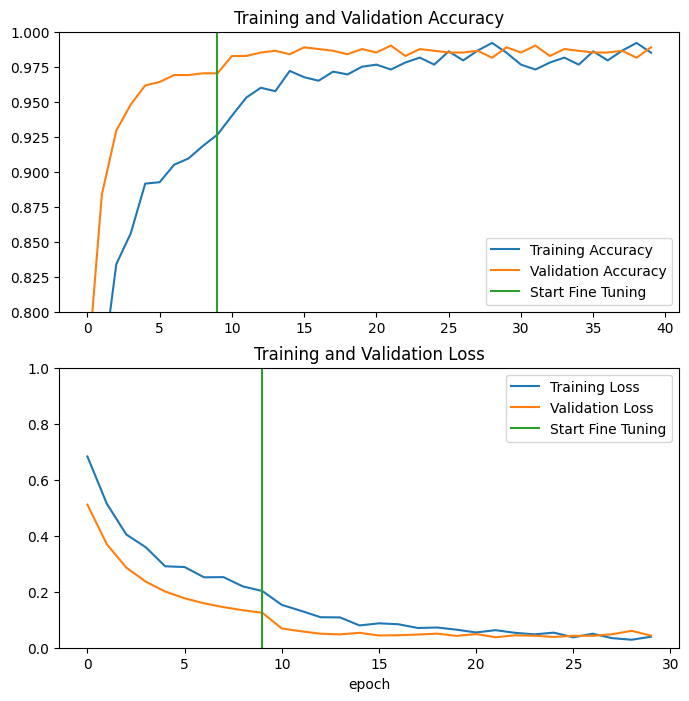

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epoch-1,initial_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epoch-1,initial_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(raw_test_ds)
print('Test accuracy :', accuracy)

6/6 [==============================] - 3s 489ms/step - loss: 0.0307 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Predictions:
 [1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0]
Labels:
 [1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0]


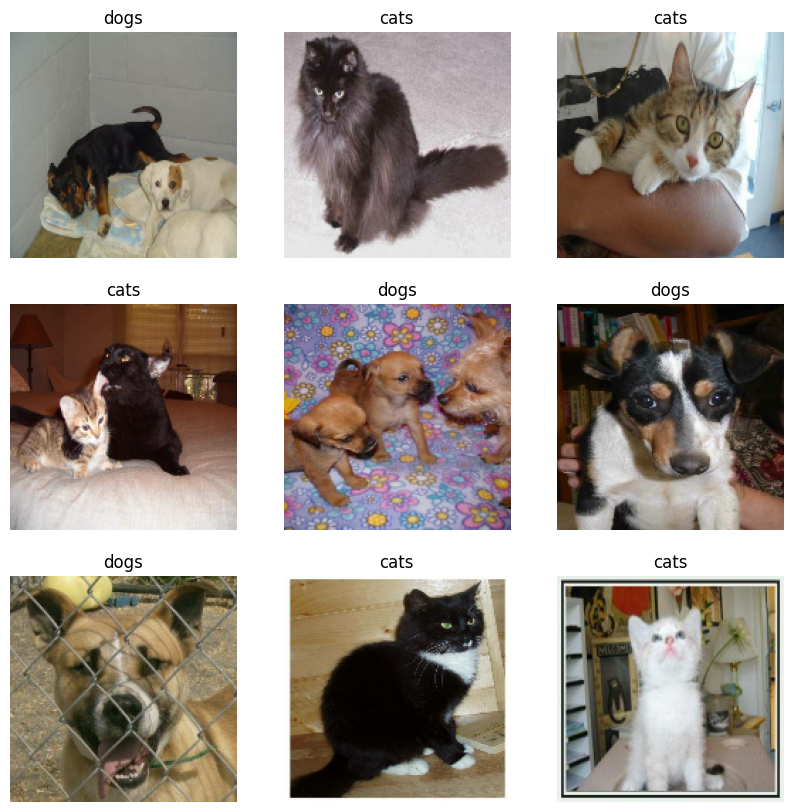

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = raw_test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")